# Image Segmentation using Pytorch
Table of Content: 

1. **Step 1: Load and datasets using torchvision**
2. **Step 2: Create Unet Architecture**
    - Define a Network
    - Define a loss function, Optimizer, lr scheduler
3. **Step 3: Neural Net Configuration **
    - Train the network on the training data
4. **Step 4: Dice Score**
    - Valid the network on the Train/Valid data
    - This competition is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. where X is the predicted set of pixels and Y is the ground truth. The Dice coefficient is defined to be 1 when both X and Y are empty. The leaderboard score is the mean of the Dice coefficients for each <Image, Label> pair in the test set.

    - The formula is given by: 
    
    **2∗|X∩Y|/|X|+|Y| **
    
    
    
**5. Step 5: Pending:**

   - Precision, recall, F-score and a ROC curve for EACH class.?? We need to calculate
   - Multiple fold scores


## Features of this kernel 
* Using Unet Architecture
* Processing output by removing mask that occur on black part of input image
* Drawing convex hull before optimizing thresholds

## Unet architecture
Unet: The UNET architecture contains two paths. First path is the contraction path (also called as the encoder) which is used to capture the context in the image. The encoder is just a traditional stack of convolutional and max pooling layers. The second path is the symmetric expanding path (also called as the decoder) which is used to enable precise localization using transposed convolutions. 

Finally Huge thanks to **artgor, ryches, ratthachat, [repo1](https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/utils/losses.py) ,[repo2](https://github.com/milesial/Pytorch-UNet) ** for their code

### **references**
1. https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
2. https://www.kaggle.com/ryches/turbo-charging-andrew-s-pytorch
3. https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/utils/losses.py
4. https://github.com/milesial/Pytorch-UNet
5. https://www.kaggle.com/ratthachat/cloud-convexhull-polygon-postprocessing-no-gpu

# Imports

In [1]:
import os
import gc
import cv2
import time
import tqdm
import random
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tq
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# ablumentations for easy image augmentation for input as well as output
import albumentations as albu
# from albumentations import torch as AT
plt.style.use('bmh')

In [2]:
# seeding function for reproducibility
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


#Resizing 525, 350
def resize_it(x):
    if x.shape != (350, 525):
        x = cv2.resize(x, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
    return x


# Dataset class for loading Data - Input images have been resized to 525, 350
class CloudDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame = None,
        datatype: str = "train",
        img_ids: np.array = None,
        transforms=albu.Compose([albu.HorizontalFlip()]), #, AT.ToTensor()
    ):
        self.df = df
        if datatype != "test":
            self.data_folder = f"{img_paths}/train_images_525/train_images_525"
        else:
            self.data_folder = f"{img_paths}/test_images_525/test_images_525"
        self.img_ids = img_ids
        self.transforms = transforms

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = np.transpose(augmented["image"], [2, 0, 1])
        mask = np.transpose(augmented["mask"], [2, 0, 1])
        return img, mask

    def __len__(self):
        return len(self.img_ids)

# Helper functions

In [3]:
# helper functions
class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']

def draw_convex_hull(mask, mode='convex'):
    
    img = np.zeros(mask.shape)
    contours, hier = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        if mode=='rect': # simple rectangle
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 255), -1)
        if mode=='convex': # minimum convex hull
            hull = cv2.convexHull(c)
            cv2.drawContours(img, [hull], 0, (255, 255, 255),-1)
        else: # minimum area rectangle
            rect = cv2.minAreaRect(c)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(img, [box], 0, (255, 255, 255),-1)
    return img/255.

def get_img(x, folder: str = "train_images_525/train_images_525"):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{img_paths}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def rle_decode(mask_rle: str = "", shape: tuple = (1400, 2100)):
    """
    Decode rle encoded mask.

    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order="F")


def make_mask(df: pd.DataFrame, image_name: str = "img.jpg", shape: tuple = (350, 525)):
    """
    Create mask based on df, image name and shape.
    """
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)
    df = df[df["img_name"] == image_name]
    for idx, im_name in enumerate(df["img_name"].values):
        for classidx, classid in enumerate(["Fish", "Flower", "Gravel", "Sugar"]):
            mask = cv2.imread(
                "../input/understanding-clouds-resized/train_masks_525/train_masks_525/"
                + classid
                + im_name
            )
            if mask is None:
                continue
            if mask[:, :, 0].shape != (350, 525):
                mask = cv2.resize(mask, (525, 350))
            masks[:, :, classidx] = mask[:, :, 0]
    masks = masks / 255
    return masks


def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype("float32")


def mask2rle(img):
    """
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: "Fish", 1: "Flower", 2: "Gravel", 3: "Sugar"}

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f"Mask {class_dict[i]}", fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title("Original image", fontsize=fontsize)

        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f"Original mask {class_dict[i]}", fontsize=fontsize)

        ax[1, 0].imshow(image)
        ax[1, 0].set_title("Transformed image", fontsize=fontsize)

        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(
                f"Transformed mask {class_dict[i]}", fontsize=fontsize
            )


def visualize_with_raw(
    image, mask, original_image=None, original_mask=None, raw_image=None, raw_mask=None
):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: "Fish", 1: "Flower", 2: "Gravel", 3: "Sugar"}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title("Original image", fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f"Original mask {class_dict[i]}", fontsize=fontsize)

    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title("Original image", fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mask[:, :, i])
        ax[1, i + 1].set_title(f"Raw predicted mask {class_dict[i]}", fontsize=fontsize)

    ax[2, 0].imshow(image)
    ax[2, 0].set_title("Transformed image", fontsize=fontsize)

    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(
            f"Predicted mask with processing {class_dict[i]}", fontsize=fontsize
        )


def plot_with_augmentation(image, mask, augment):
    """
    Wrapper for `visualize` function.
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented["image"]
    mask_flipped = augmented["mask"]
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)


# sigmoid = lambda x: 1 / (1 + np.exp(-x))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))



def post_process(probability, threshold, min_size):
    """
    This is slightly different from other kernels as we draw convex hull here itself.
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    # don't remember where I saw it
    mask = (cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1])
    mask = draw_convex_hull(mask.astype(np.uint8))
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = component == c
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(
            scale_limit=0.5,
            rotate_limit=0,
            shift_limit=0.1,
            p=0.5,
            border_mode=0
        ),
        albu.GridDistortion(p=0.5),
        albu.Resize(320, 640),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 640),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
    return albu.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2.0 * intersection.sum() / (img1.sum() + img2.sum())

def dice_no_threshold(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None,
):
    """
    Reference:
    https://catalyst-team.github.io/catalyst/_modules/catalyst/dl/utils/criterion/dice.html
    """
    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets) + torch.sum(outputs)
    dice = 2 * intersection / (union + eps)

    return dice

## Loss function definition
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=1., 
                           eps=self.eps, threshold=None, 
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce)

## RAdam Optimizer
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
            
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

In [4]:
path = "../input/understanding_cloud_organization"
img_paths = "../input/understanding-clouds-resized"
train_on_gpu = torch.cuda.is_available()
SEED = 2019
MODEL_NO = 0 # in K-fold
N_FOLDS = 5 # in K-fold
seed_everything(SEED)
os.listdir(path)

['sample_submission.csv', 'train.csv', 'train_images', 'test_images']

## Step 1: Load and datasets using torchvision

- Make split in train test validation

In [5]:
#Get target label and image name in separate column
train = pd.read_csv(f"{path}/train.csv")
train["label"] = train["Image_Label"].apply(lambda x: x.split("_")[1])
train["img_name"] = train["Image_Label"].apply(lambda x: x.split("_")[0])
sub = pd.read_csv(f"{path}/sample_submission.csv")
sub["label"] = sub["Image_Label"].apply(lambda x: x.split("_")[1])
sub["img_name"] = sub["Image_Label"].apply(lambda x: x.split("_")[0])
train.head()

,Image_Label,EncodedPixels,label,img_name
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,Fish,0011165.jpg
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,Flower,0011165.jpg
2,0011165.jpg_Gravel,NaN,Gravel,0011165.jpg
3,0011165.jpg_Sugar,NaN,Sugar,0011165.jpg
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,Fish,002be4f.jpg


In [6]:
# get image and segment mask count on each image
id_mask_count = (
    train.loc[train["EncodedPixels"].isnull() == False, "Image_Label"]
    .apply(lambda x: x.split("_")[0])
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={"index": "img_id", "Image_Label": "count"})
)

ids = id_mask_count["img_id"].values

#StratifiedKFold split - count of segments
li = [
    [train_index, test_index]
    for train_index, test_index in StratifiedKFold(
        n_splits=N_FOLDS, random_state=SEED
    ).split(ids, id_mask_count["count"])
]
print(N_FOLDS, " folds and Size of each train set", len(li[0][0]), " and valid set", len(li[0][1]))

5  folds and Size of each train set 4435  and valid set 1111


In [7]:
train_ids, valid_ids = ids[li[MODEL_NO][0]], ids[li[MODEL_NO][1]]  ##Only Kfold 0 is trained here
test_ids = sub["Image_Label"].apply(lambda x: x.split("_")[0]).drop_duplicates().values

print(f"training set   {train_ids[:5]}.. with length {len(train_ids)}")
print(f"validation set {valid_ids[:5]}.. with length {len(valid_ids)}")
print(f"testing set    {test_ids[:5]}.. with length {len(test_ids)}")

training set   ['2b03476.jpg' '2ba6090.jpg' '2d09e66.jpg' '2e4f5ab.jpg' '2f1f439.jpg'].. with length 4435
validation set ['0011165.jpg' '002be4f.jpg' '0031ae9.jpg' '0035239.jpg' '003994e.jpg'].. with length 1111
testing set    ['002f507.jpg' '0035ae9.jpg' '0038327.jpg' '004f759.jpg' '005ba08.jpg'].. with length 3698


##### Load and datasets using torchvision

In [8]:
# Load dataset and dataloader
num_workers = 2
bs = 12
train_dataset = CloudDataset(
    df=train,
    datatype="train",
    img_ids=train_ids,
    transforms=get_training_augmentation(),
)
valid_dataset = CloudDataset(
    df=train,
    datatype="valid",
    img_ids=valid_ids,
    transforms=get_validation_augmentation(),
)

train_loader = DataLoader(
    train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers
)
valid_loader = DataLoader(
    valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers
)

## Step 2: Create Unet Architecture: Model Defination

In [9]:
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)
    
model = UNet(n_channels=3, n_classes=4).float()
if train_on_gpu:
    model.cuda()

## Step 3: Neural Net Configuration and Training loop

In [10]:
model # print Model

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

In [11]:
criterion = BCEDiceLoss(eps=1.0, activation=None)
optimizer = RAdam(model.parameters(), lr = 0.005)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)

In [12]:
# number of epochs to train the model
n_epochs = 15
train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
valid_loss_min = np.Inf # track change in validation loss
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    bar = tq(train_loader, postfix={"train_loss":0.0})
    for data, target in bar:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        #print(loss)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        bar.set_postfix(ordered_dict={"train_loss":loss.item()})
    ######################    
    # validate the model #
    ######################
    model.eval()
    del data, target
    with torch.no_grad():
        bar = tq(valid_loader, postfix={"valid_loss":0.0, "dice_score":0.0})
        for data, target in bar:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
            dice_score +=  dice_cof * data.size(0)
            bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    dice_score = dice_score/len(valid_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    dice_score_list.append(dice_score)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {:.6f}'.format(
        epoch, train_loss, valid_loss, dice_score))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
    
    scheduler.step(valid_loss)


Epoch: 1  Training Loss: 1.062620  Validation Loss: 1.128823 Dice Score: 0.392849
Validation loss decreased (inf --> 1.128823).  Saving model ...



Epoch: 2  Training Loss: 0.966404  Validation Loss: 0.999398 Dice Score: 0.420916
Validation loss decreased (1.128823 --> 0.999398).  Saving model ...



Epoch: 3  Training Loss: 0.939569  Validation Loss: 1.001698 Dice Score: 0.400903



Epoch: 4  Training Loss: 0.926679  Validation Loss: 0.987232 Dice Score: 0.433442
Validation loss decreased (0.999398 --> 0.987232).  Saving model ...



Epoch: 5  Training Loss: 0.913111  Validation Loss: 0.974675 Dice Score: 0.426292
Validation loss decreased (0.987232 --> 0.974675).  Saving model ...



Epoch: 6  Training Loss: 0.901612  Validation Loss: 0.927240 Dice Score: 0.426461
Validation loss decreased (0.974675 --> 0.927240).  Saving model ...



Epoch: 7  Training Loss: 0.888923  Validation Loss: 1.119475 Dice Score: 0.393021



Epoch: 8  Training Loss: 0.888071  Validation Loss: 1.106451 Dice Score: 0.395074



Epoch: 9  Training Loss: 0.870753  Validation Loss: 0.900618 Dice Score: 0.472563
Validation loss decreased (0.927240 --> 0.900618).  Saving model ...



Epoch: 10  Training Loss: 0.872141  Validation Loss: 0.882254 Dice Score: 0.473124
Validation loss decreased (0.900618 --> 0.882254).  Saving model ...



Epoch: 11  Training Loss: 0.863613  Validation Loss: 1.078992 Dice Score: 0.419052



Epoch: 12  Training Loss: 0.859704  Validation Loss: 0.935651 Dice Score: 0.436164



Epoch: 15  Training Loss: 0.854199  Validation Loss: 0.882152 Dice Score: 0.463434


## Step 4: Dice Score and Training Metric

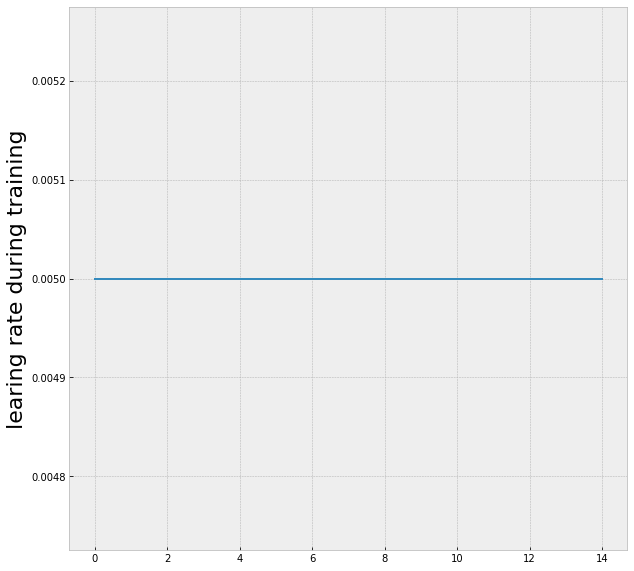

In [13]:
plt.figure(figsize=(10,10))
plt.plot([i[0] for i in lr_rate_list])
plt.ylabel('learing rate during training', fontsize=22)
plt.show()

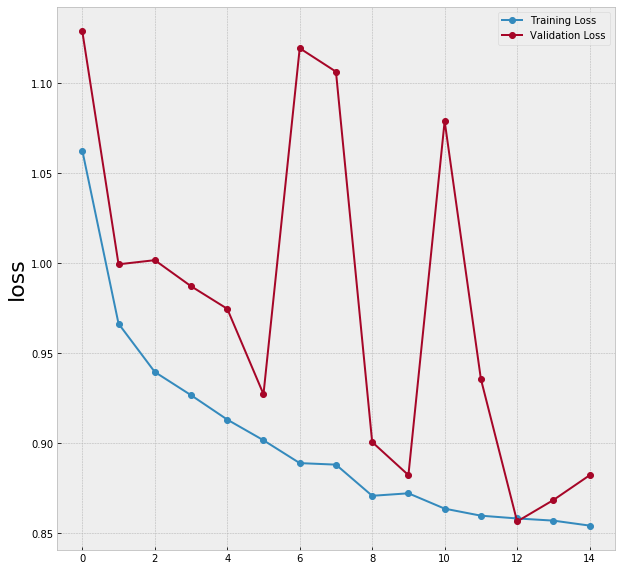

In [14]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('loss', fontsize=22)
plt.legend()
plt.show()

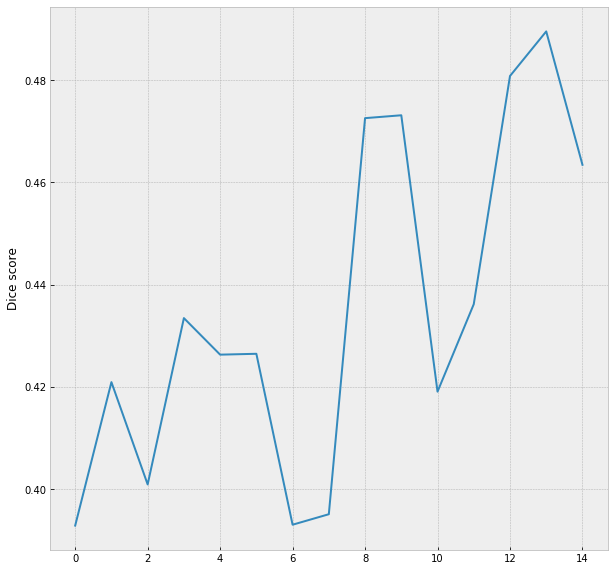

In [15]:
plt.figure(figsize=(10,10))
plt.plot(dice_score_list)
plt.ylabel('Dice score')
plt.show()

In [16]:
# load best model
model.load_state_dict(torch.load('model_cifar.pt'))
model.eval();

In [17]:
valid_masks = []
count = 0
tr = min(len(valid_ids)*4, 2000)
probabilities = np.zeros((tr, 350, 525), dtype = np.float32)
for data, target in tq(valid_loader):
    if train_on_gpu:
        data = data.cuda()
    target = target.cpu().detach().numpy()
    outpu = model(data).cpu().detach().numpy()
    for p in range(data.shape[0]):
        output, mask = outpu[p], target[p]
        for m in mask:
            valid_masks.append(resize_it(m))
        for probability in output:
            probabilities[count, :, :] = resize_it(probability)
            count += 1
        if count >= tr - 1:
            break
    if count >= tr - 1:
        break

## Grid Search for best Threshold

In [18]:
class_params = {}
for class_id in range(4):
    print(class_id)
    attempts = []
    for t in range(0, 100, 5):
        t /= 100
        for ms in [0, 100, 1200, 5000, 10000, 30000]:
            masks, d = [], []
            for i in range(class_id, len(probabilities), 4):
                probability = probabilities[i]
                predict, num_predict = post_process(probability, t, ms)
                masks.append(predict)
            for i, j in zip(masks, valid_masks[class_id::4]):
                if (i.sum() == 0) & (j.sum() == 0):
                    d.append(1)
                else:
                    d.append(dice(i, j))
            attempts.append((t, ms, np.mean(d)))

    attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])
    attempts_df = attempts_df.sort_values('dice', ascending=False)
    print(attempts_df.head())
    best_threshold = attempts_df['threshold'].values[0]
    best_size = attempts_df['size'].values[0]
    class_params[class_id] = (best_threshold, best_size)

0
    threshold   size      dice
95       0.75  30000  0.580601
89       0.70  30000  0.570783
83       0.65  30000  0.568943
71       0.55  30000  0.567054
77       0.60  30000  0.566163
1
    threshold   size      dice
88       0.70  10000  0.708602
47       0.35  30000  0.703577
41       0.30  30000  0.702484
35       0.25  30000  0.700892
82       0.65  10000  0.700544
2
    threshold   size      dice
77       0.60  30000  0.616275
83       0.65  30000  0.609073
71       0.55  30000  0.604686
89       0.70  30000  0.602223
65       0.50  30000  0.595429
3
    threshold   size      dice
70       0.55  10000  0.575804
58       0.45  10000  0.572134
64       0.50  10000  0.568256
76       0.60  10000  0.565466
82       0.65  10000  0.563838


In [19]:
del masks
del valid_masks
del probabilities
gc.collect()

7342

In [20]:
attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])
print(class_params)

{0: (0.75, 30000), 1: (0.7, 10000), 2: (0.6, 30000), 3: (0.55, 10000)}


In [21]:
attempts_df.groupby(['threshold'])['dice'].max()

threshold
0.00    0.253619
0.05    0.453407
0.10    0.512007
0.15    0.519251
0.20    0.531053
0.25    0.534656
0.30    0.532807
0.35    0.550858
0.40    0.563741
0.45    0.572134
0.50    0.568256
0.55    0.575804
0.60    0.565466
0.65    0.563838
0.70    0.554717
0.75    0.539974
0.80    0.510521
0.85    0.470748
0.90    0.415814
0.95    0.332429
Name: dice, dtype: float64

In [22]:
attempts_df.groupby(['size'])['dice'].max()

size
0        0.500229
100      0.514080
1200     0.535644
5000     0.558991
10000    0.575804
30000    0.534656
Name: dice, dtype: float64

In [23]:
attempts_df = attempts_df.sort_values('dice', ascending=False)
attempts_df.head(10)

,threshold,size,dice
70,0.55,10000,0.575804
58,0.45,10000,0.572134
64,0.50,10000,0.568256
76,0.60,10000,0.565466
82,0.65,10000,0.563838
52,0.40,10000,0.563741
81,0.65,5000,0.558991
75,0.60,5000,0.558771
69,0.55,5000,0.554894
87,0.70,5000,0.554717


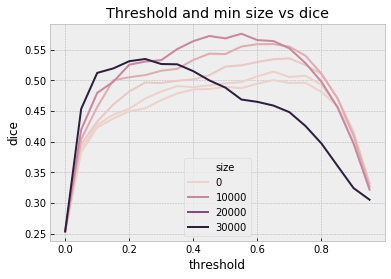

In [24]:
sns.lineplot(x='threshold', y='dice', hue='size', data=attempts_df);
plt.title('Threshold and min size vs dice');

In [25]:
best_threshold = attempts_df['threshold'].values[0]
best_size = attempts_df['size'].values[0]

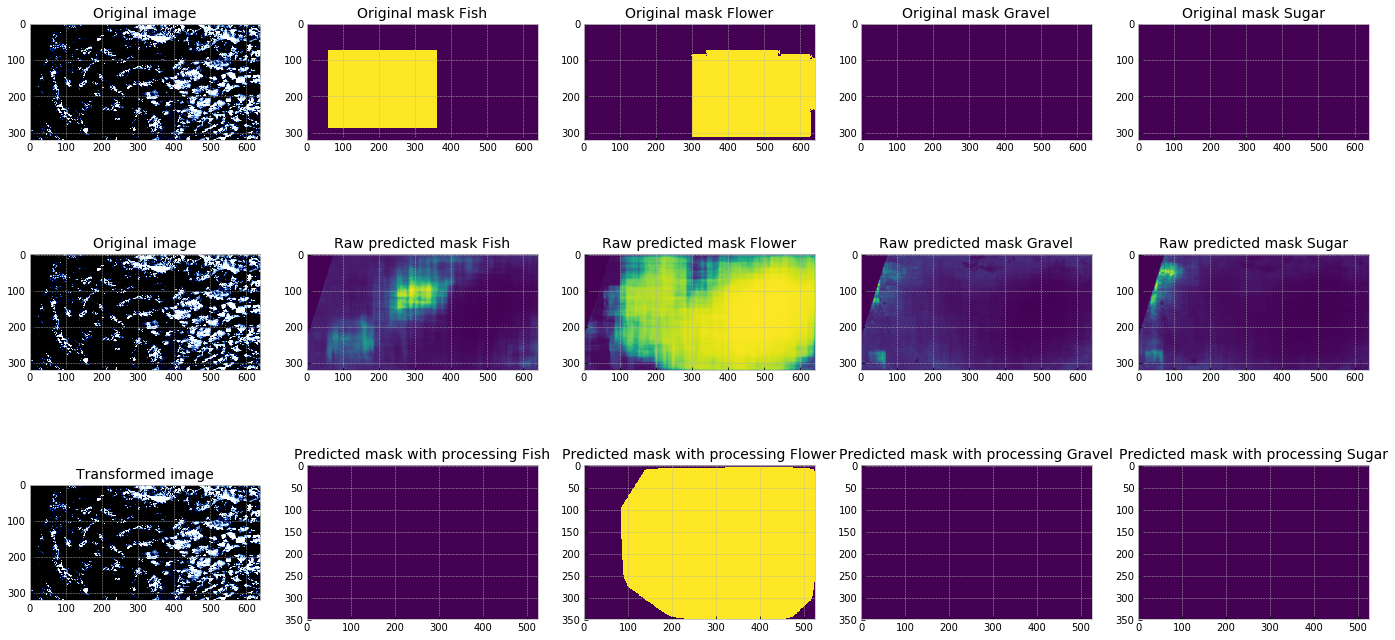

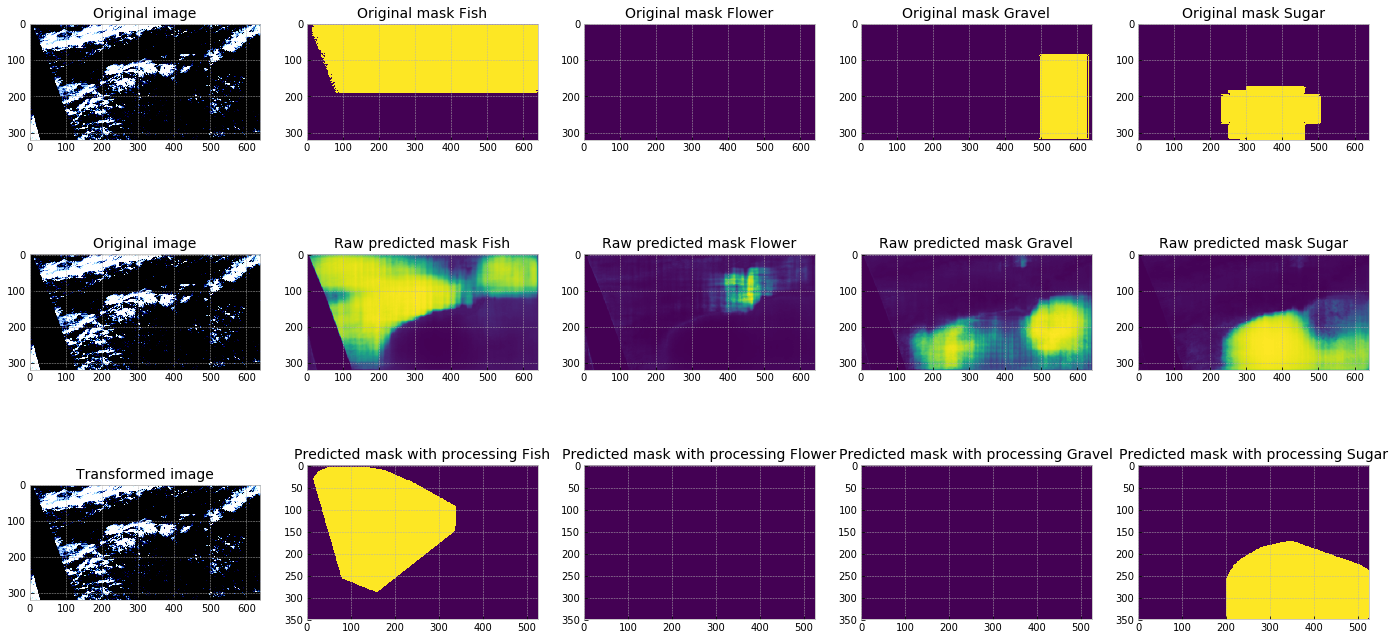

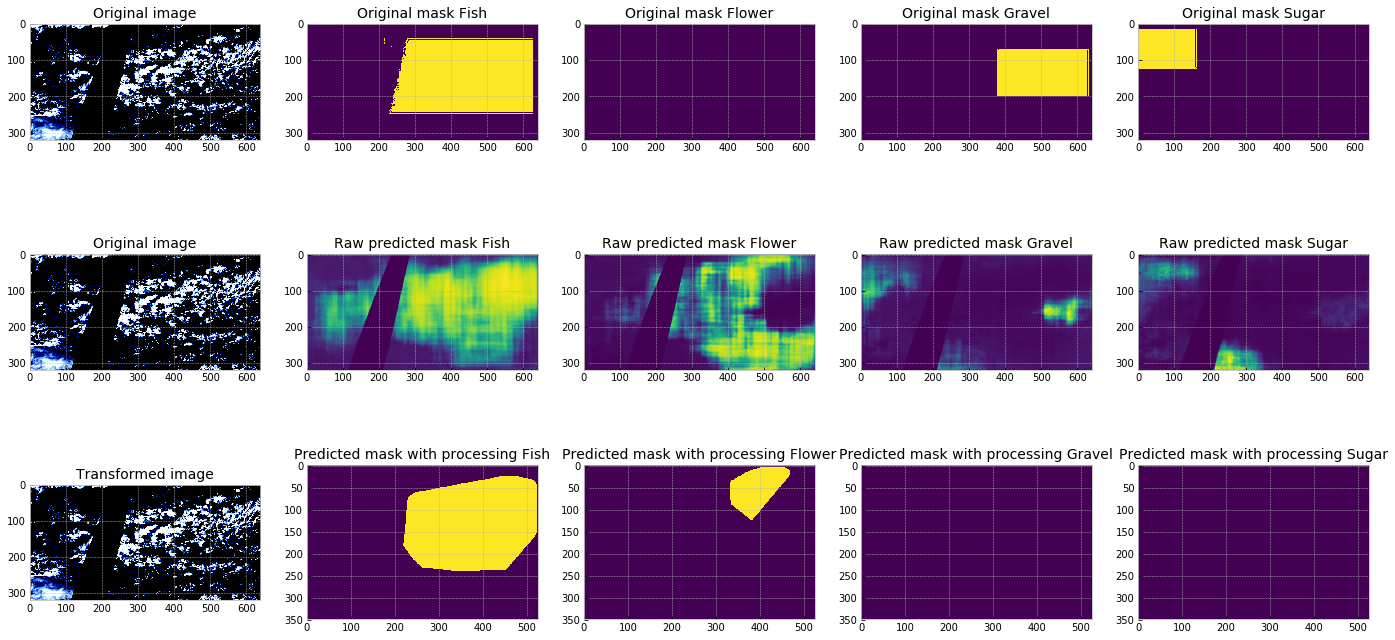

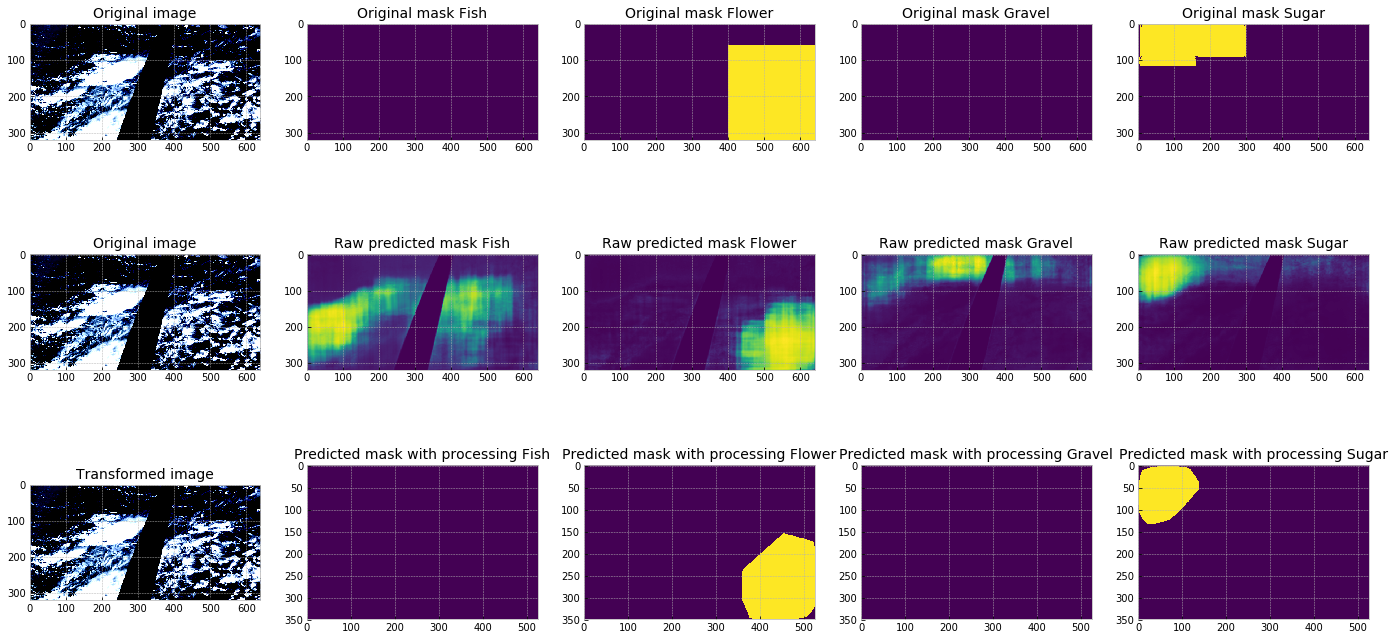

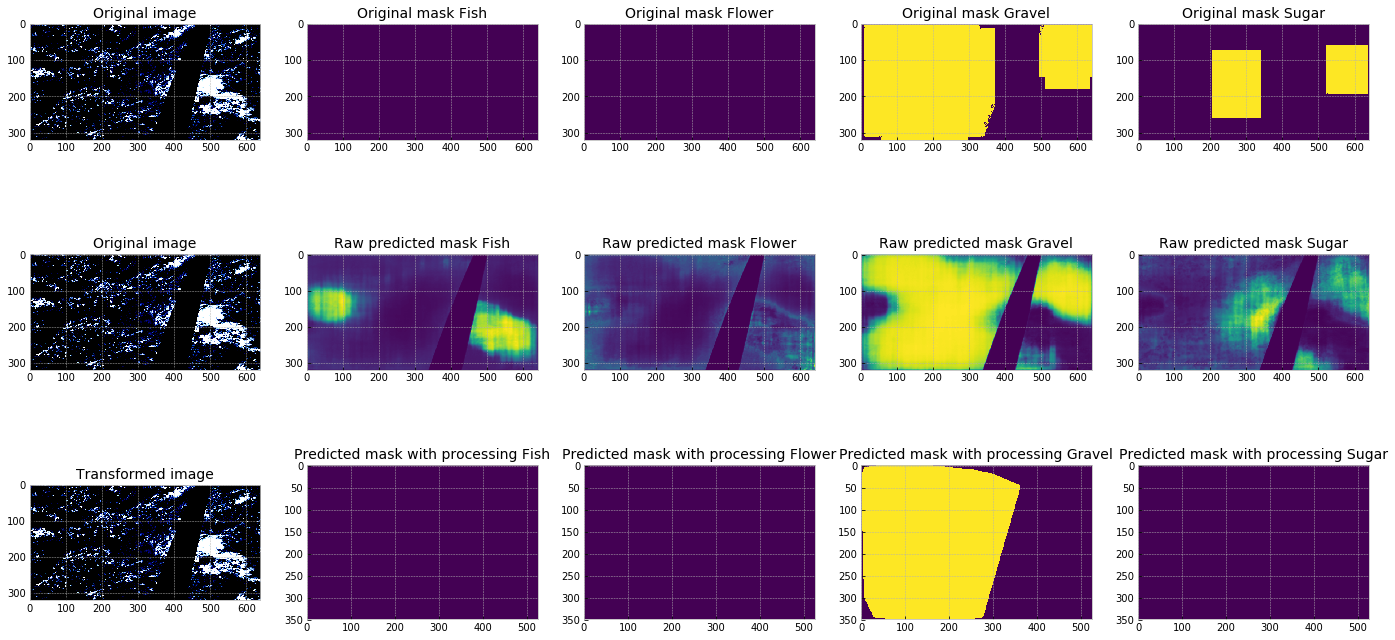

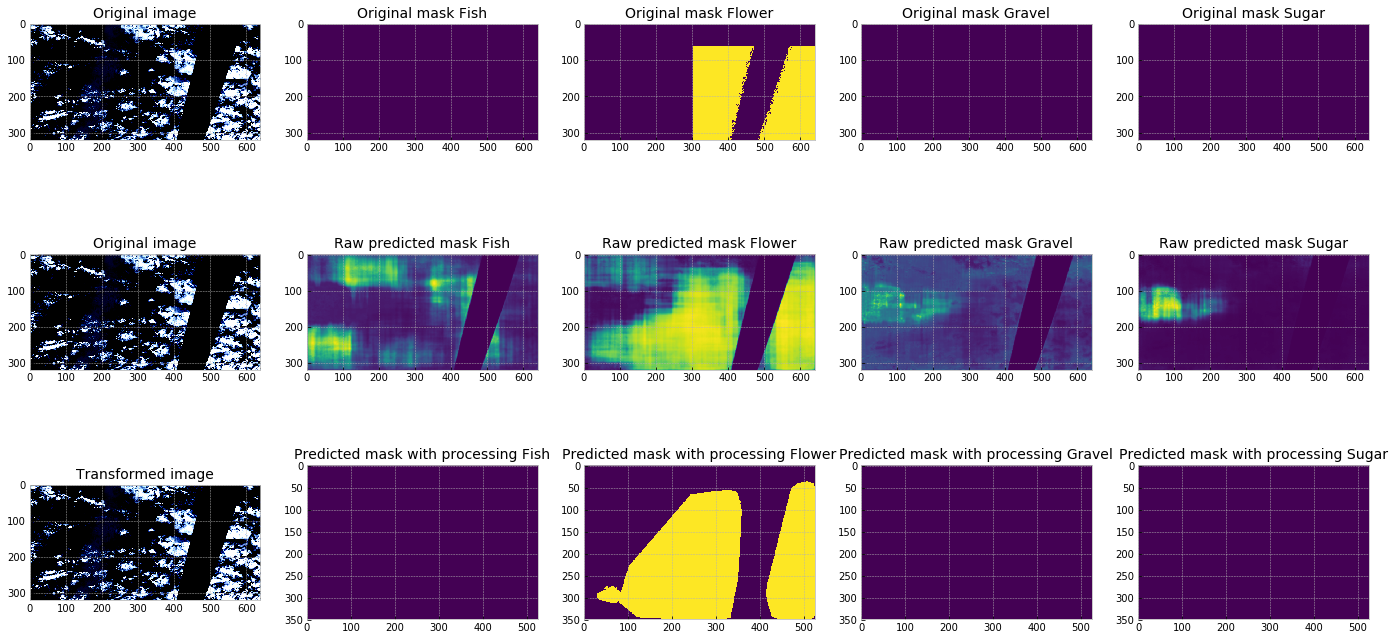

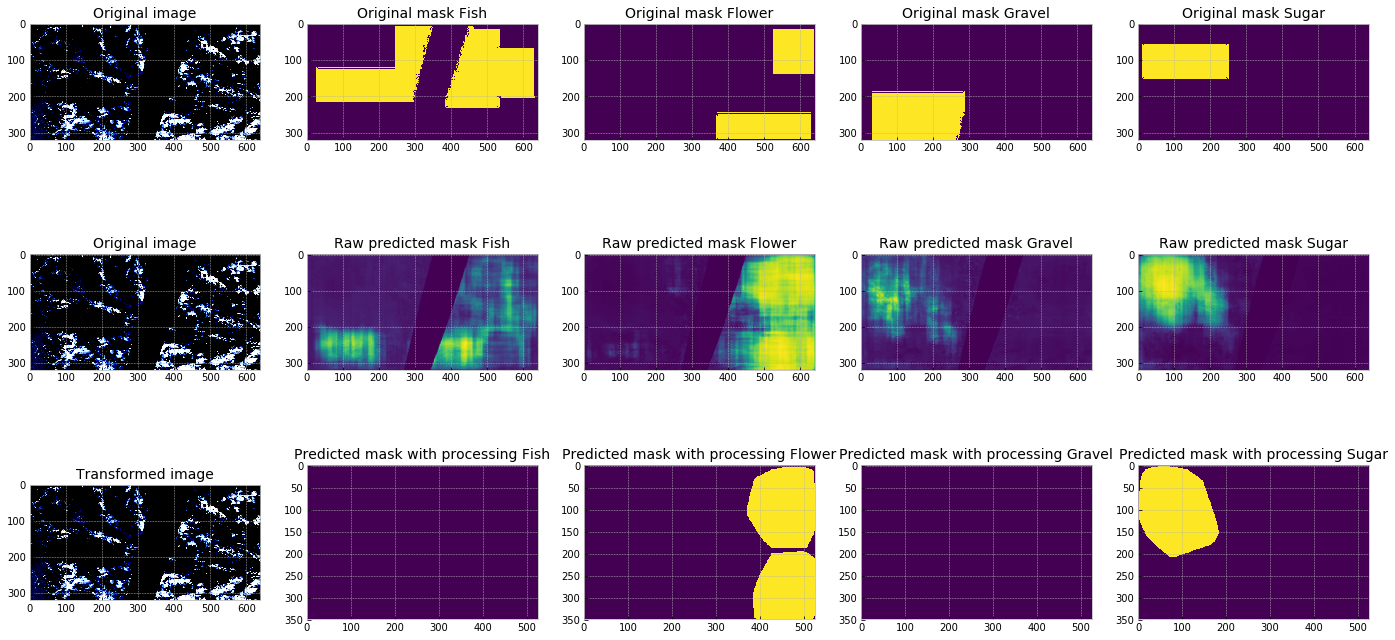

In [26]:
for i, (data, target) in enumerate(valid_loader):
    if train_on_gpu:
        data = data.cuda()
    output = ((model(data))[0]).cpu().detach().numpy()
    image  = data[0].cpu().detach().numpy()
    mask   = target[0].cpu().detach().numpy()
    output = output.transpose(1 ,2, 0)
    image_vis = image.transpose(1, 2, 0)
    mask = mask.astype('uint8').transpose(1, 2, 0)
    pr_mask = np.zeros((350, 525, 4))
    for j in range(4):
        probability = resize_it(output[:, :, j])
        pr_mask[:, :, j], _ = post_process(probability,
                                           class_params[j][0],
                                           class_params[j][1])
    visualize_with_raw(image=image_vis, mask=pr_mask,
                      original_image=image_vis, original_mask=mask,
                      raw_image=image_vis, raw_mask=output)
    if i >= 6:
        break

In [27]:
torch.cuda.empty_cache()
gc.collect()

222778

In [28]:
test_dataset = CloudDataset(df=sub,
                            datatype='test', 
                            img_ids=test_ids,
                            transforms=get_validation_augmentation())
test_loader = DataLoader(test_dataset, batch_size=4,
                         shuffle=False, num_workers=2)

In [29]:
del train_dataset, train_loader
del valid_dataset, valid_loader
gc.collect()

0

## Prepare Submission

In [30]:
subm = pd.read_csv("../input/understanding_cloud_organization/sample_submission.csv")
pathlist = ["../input/understanding_cloud_organization/test_images/" + i.split("_")[0] for i in subm['Image_Label']]

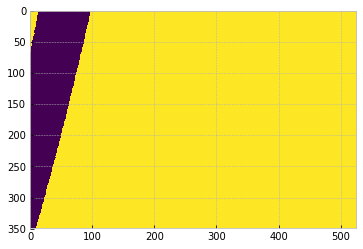

In [31]:
def get_black_mask(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (525,350))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 0, 0], np.uint8)
    upper = np.array([180, 255, 10], np.uint8)
    return (~ (cv2.inRange(hsv, lower, upper) > 250)).astype(int)

plt.imshow(get_black_mask(pathlist[120]))
plt.show()

In [32]:
encoded_pixels = []
image_id = 0
cou = 0
np_saved = 0
for data, target in tq(test_loader):
    if train_on_gpu:
        data = data.cuda()
    output = model(data)
    del data
    for i, batch in enumerate(output):
        for probability in batch:
            probability = resize_it(probability.cpu().detach().numpy())
            predict, num_predict = post_process(probability,
                                                class_params[image_id % 4][0],
                                                class_params[image_id % 4][1])
            if num_predict == 0:
                encoded_pixels.append('')
            else:
                black_mask = get_black_mask(pathlist[cou])
                np_saved += np.sum(predict)
                predict = np.multiply(predict, black_mask)
                np_saved -= np.sum(predict)
                r = mask2rle(predict)
                encoded_pixels.append(r)
            cou += 1
            image_id += 1

print(f"number of pixel saved {np_saved}")


number of pixel saved 520843.0


In [33]:
sub['EncodedPixels'] = encoded_pixels
sub.to_csv('submission.csv', columns=['Image_Label', 'EncodedPixels'], index=False)